In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import os
os.chdir('/content/drive/MyDrive/EPInformer/github/EPInformer')

In [4]:
!pip install kipoiseq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.0/103.0 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 79.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 11.1 MB/s eta 0:00:00
  Attempting uninstall: attrs
    Found existing installation: attrs 23.2.0
    Uninstalling attrs-23.2.0:
      Succes

In [19]:
from EPInformer.models import EPInformer_v2, enhancer_predictor_256bp
from scripts.utils import prepare_input
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from tqdm import tqdm
import torch
from torch.utils.data import Subset, Dataset
import scripts.train_EPInformer as train

In [8]:
# Download K562 training data from Zenodo
!wget https://zenodo.org/records/12738705/files/K562_DNase_ENCFF257HEE_2kb_4DNFITUOMFUQ_enhancer_promoter_encoding.h5.zip -P ./data/
!wget https://zenodo.org/records/12738705/files/K562_DNase_ENCFF257HEE_hic_4DNFITUOMFUQ_1MB_ABC_nominated.zip -P ./data/
!unzip -o -qq ./data/K562_DNase_ENCFF257HEE_2kb_4DNFITUOMFUQ_enhancer_promoter_encoding.h5.zip -d ./data/ -o
!unzip -o -qq ./data/K562_DNase_ENCFF257HEE_hic_4DNFITUOMFUQ_1MB_ABC_nominated.zip -d ./data/ -o

--2024-07-14 07:09:11--  https://zenodo.org/records/12738705/files/K562_DNase_ENCFF257HEE_2kb_4DNFITUOMFUQ_enhancer_promoter_encoding.h5.zip
Resolving zenodo.org (zenodo.org)... 188.184.98.238, 188.184.103.159, 188.185.79.172, ...
Connecting to zenodo.org (zenodo.org)|188.184.98.238|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 198484714 (189M) [application/octet-stream]
Saving to: ‘./data/K562_DNase_ENCFF257HEE_2kb_4DNFITUOMFUQ_enhancer_promoter_encoding.h5.zip’

K562_DNase_ENCFF257 100%[===================>] 189.29M  14.7MB/s    in 11s     

2024-07-14 07:09:22 (17.5 MB/s) - ‘./data/K562_DNase_ENCFF257HEE_2kb_4DNFITUOMFUQ_enhancer_promoter_encoding.h5.zip’ saved [198484714/198484714]

--2024-07-14 07:09:23--  https://zenodo.org/records/12738705/files/K562_DNase_ENCFF257HEE_hic_4DNFITUOMFUQ_1MB_ABC_nominated.zip
Resolving zenodo.org (zenodo.org)... 188.184.98.238, 188.184.103.159, 188.185.79.172, ...
Connecting to zenodo.org (zenodo.org)|188.184.98.238|:443

## Reproduce prediction results

In [4]:
split_df = pd.read_csv('./data/leave_chrom_out_crossvalidation_split_18377genes.csv', index_col=0)

In [14]:
cell = 'K562'
distance_threshold = 100_000
n_enhancers = 60
device = 'cuda'
# num_feature == 1: distance; num_feature == 2: distance + enhancer activity; num_feature == 3: distance + enhancer activity + hic contacts
n_extraFeat = 3
batch_size = 16
expr_type = 'RNA'
prediction_res = []
for fi in range(1, 13):
    print("-"*10, 'fold', fi, '-'*10)
    fold_i = 'fold_' + str(fi)

    train_ensid = split_df[split_df[fold_i] == 'train'].index
    valid_ensid = split_df[split_df[fold_i] == 'valid'].index
    test_ensid = split_df[split_df[fold_i] == 'test'].index

    all_ds = train.promoter_enhancer_dataset(expr_type=expr_type, signal_type='H3K27ac', usePromoterSignal=True, cell_type=cell, n_extraFeat=n_extraFeat, n_enhancers=n_enhancers, distance_threshold=distance_threshold)
    ensid_list = [eid.decode() for eid in all_ds.data_h5['ensid'][:]]
    ensid_df = pd.DataFrame(ensid_list, columns=['ensid'])
    ensid_df['idx'] = np.arange(len(ensid_list))
    ensid_df = ensid_df.set_index('ensid')
    train_idx = ensid_df.loc[train_ensid]['idx']
    valid_idx = ensid_df.loc[valid_ensid]['idx']
    test_idx = ensid_df.loc[test_ensid]['idx']

    train_ds = Subset(all_ds, train_idx)
    valid_ds = Subset(all_ds, valid_idx)
    test_ds = Subset(all_ds, test_idx)

    model = EPInformer_v2(n_encoder=3, n_enhancer=n_enhancers, out_dim=64, n_extraFeat=3, device=device)
    checkpoint = torch.load("./trained_models/EPInformer_PE_Activity_HiC/K562/fold_{}_EPInformer_PE_Activity_HiC_{}_K562_checkpoint.pt".format(fi, expr_type))
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    test_df = train.test(model, test_ds, fold_i=fi, batch_size=batch_size, device=device)
    prediction_res.append(test_df)
prediction_res = pd.concat(prediction_res)

---------- fold 1 ----------


100%|██████████| 137/137 [00:32<00:00,  4.23it/s]

R_square of the network on fold 1 test sequence: 0.771
Pearson R: 0.8779392216472542


Pearson R of gene with enhancer 0.8779392216472542
---------- fold 2 ----------


100%|██████████| 83/83 [00:30<00:00,  2.73it/s]

R_square of the network on fold 2 test sequence: 0.790
Pearson R: 0.888539804822417


Pearson R of gene with enhancer 0.888539804822417
---------- fold 3 ----------


100%|██████████| 82/82 [00:27<00:00,  3.03it/s]

R_square of the network on fold 3 test sequence: 0.767
Pearson R: 0.8757204543402186


Pearson R of gene with enhancer 0.8757204543402186
---------- fold 4 ----------


100%|██████████| 86/86 [00:25<00:00,  3.35it/s]

R_square of the network on fold 4 test sequence: 0.793
Pearson R: 0.8905612152928397


Pearson R of gene with enhancer 0.8905612152928397
---------- fold 5 ----------


100%|██████████| 108/108 [00:27<00:00,  3.95it/s]

R_square of the network on fold 5 test sequence: 0.677
Pearson R: 0.8224997544268596


Pearson R of gene with enhancer 0.8224997544268596
---------- fold 6 ----------


100%|██████████| 118/118 [00:28<00:00,  4.16it/s]

R_square of the network on fold 6 test sequence: 0.737
Pearson R: 0.8586209621605276


Pearson R of gene with enhancer 0.8586209621605276
---------- fold 7 ----------


100%|██████████| 56/56 [00:13<00:00,  4.28it/s]

R_square of the network on fold 7 test sequence: 0.793
Pearson R: 0.8903148852601397


Pearson R of gene with enhancer 0.8903148852601397
---------- fold 8 ----------


100%|██████████| 128/128 [00:30<00:00,  4.21it/s]

R_square of the network on fold 8 test sequence: 0.716
Pearson R: 0.8459570578568875


Pearson R of gene with enhancer 0.8459570578568875
---------- fold 9 ----------


100%|██████████| 76/76 [00:17<00:00,  4.23it/s]

R_square of the network on fold 9 test sequence: 0.761
Pearson R: 0.872275720813474


Pearson R of gene with enhancer 0.872275720813474
---------- fold 10 ----------


100%|██████████| 89/89 [00:20<00:00,  4.25it/s]

R_square of the network on fold 10 test sequence: 0.769
Pearson R: 0.876990133860337


Pearson R of gene with enhancer 0.876990133860337
---------- fold 11 ----------


100%|██████████| 73/73 [00:17<00:00,  4.23it/s]

R_square of the network on fold 11 test sequence: 0.610
Pearson R: 0.7810770902454418


Pearson R of gene with enhancer 0.7810770902454418
---------- fold 12 ----------


100%|██████████| 119/119 [00:28<00:00,  4.24it/s]

R_square of the network on fold 12 test sequence: 0.800
Pearson R: 0.8946413483622402
Pearson R of gene with enhancer 0.8946413483622402


In [24]:
pearsonR, pv = stats.pearsonr(prediction_res['Pred'], prediction_res['actual'])
print('PearsonR of 12-fold cross-validation predicitons', pearsonR)

PearsonR of 12-fold cross-validation predicitons 0.8630696328085073


<Figure size 600x600 with 0 Axes>

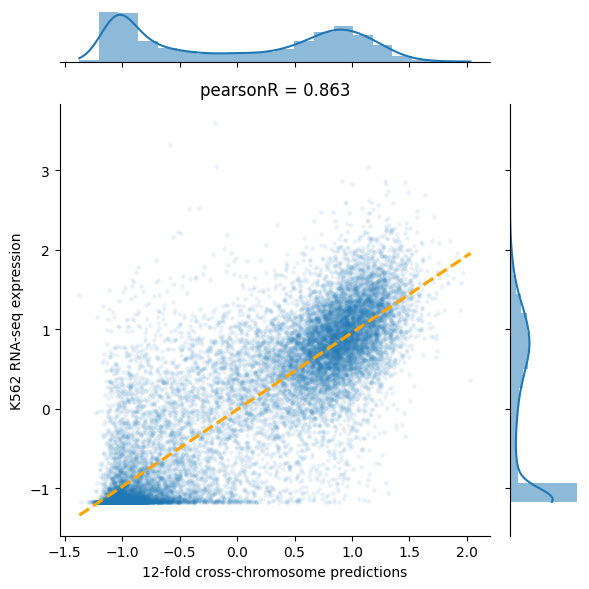

In [23]:
plt.figure(figsize=(6,6))
ax = sns.jointplot(
    data=prediction_res,
    x="Pred",
    y="actual",
    kind = 'scatter',
    joint_kws={'marker':'o', 's':10, 'alpha':0.1, 'linewidth':0},
    marginal_kws={'bins':20, 'element':'step', 'kde':True, 'linewidth':0},
)
ax.plot_joint(sns.regplot, color="r", scatter=False, line_kws={"color": "orange", 'linestyle':'dashed'})
plt.title('pearsonR = {:.3f}'.format(pearsonR))
plt.ylabel('K562 RNA-seq expression')
plt.xlabel('12-fold cross-chromosome predictions')
plt.tight_layout()

## Predict gene expression given promoter-enhancer sequence

In [3]:
# Download ABC element-gene data for K562
!wget https://www.encodeproject.org/files/ENCFF635RHY/@@download/ENCFF635RHY.bed.gz -O ./data/K562_enhancer_gene_links.bed.gz

./data/: Is a directory


In [ ]:
# Donwload reference genome
!wget https://hgdownload.soe.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz  -P ./data/
!gunzip ./data/hg38.fa.gz

In [ ]:
# Load ABC enhancer-gene data
enhancer_gene_k562 = pd.read_csv('./data/K562_enhancer_gene_links.bed.gz', sep='\t')
# Select the gene-enhancer links within 100kb to the TSS of target gene and remove the promoter element
enhancer_gene_k562_100kb = enhancer_gene_k562[(enhancer_gene_k562['distance']<=100_000)&(enhancer_gene_k562['distance']>1000)].reset_index()
enhancer_gene_k562_100kb.to_csv('./data/K562_enhancer_gene_links_100kb.tsv', index=False, sep='\t')

In [ ]:
enhancer_gene_k562_100kb = pd.read_csv('./data/K562_enhancer_gene_links_100kb.tsv', sep='\t')
gene_tss = pd.read_csv('./data/GeneList_K562.txt', sep='\t')[['name', 'chr', 'tss', 'strand']]
data_split = pd.read_csv('./data/leave_chrom_out_crossvalidation_split_18377genes.csv')
enhancer_gene_k562_100kb_includeNoEnhancerGene = enhancer_gene_k562_100kb.merge(gene_tss, left_on='TargetGene', right_on='name', how='right', suffixes=['', '_gene']).reset_index()

In [ ]:
gene_list = list(data_split[data_split['fold_1'] == 'test']['Gene name'].head(16))
# encode gene-enhancer links for EPInformer
# num_feature == 1: distance; num_feature == 2: distance + enhancer activity; num_feature == 3: distance + enhancer activity + hic contacts
device = 'cpu'
PE_codes, PE_feats, mRNA_feats, PE_pairs = prepare_input(enhancer_gene_k562_100kb_includeNoEnhancerGene, gene_list, num_features=2)
PE_codes = torch.from_numpy(PE_codes).float().to(device)
PE_feats = torch.from_numpy(PE_feats).float().to(device)
mRNA_feats = torch.from_numpy(mRNA_feats).float().to(device)
print(PE_codes.shape, PE_feats.shape, mRNA_feats.shape)

100%|██████████| 16/16 [00:00<00:00, 26.04it/s]


torch.Size([16, 61, 2000, 4]) torch.Size([16, 61, 2]) torch.Size([16, 9])


In [ ]:
# Load pre-trained EPInformer-PE-Activity (CAGE-seq)
model = EPInformer_v2(n_encoder=3, n_enhancer=60, out_dim=64, n_extraFeat=2, device=device)
model_path = '../models_with_pretrained/fold_1_best_EPInformerV2.4base.64dim.3Trans.4head.TrueBN.TrueLN.TrueFeat.2extraFeat.60enh.preTrainedConv.tuneP2.K562.rmEnhNone.bs32.seq_feat_dist.DNaseH.PSignal.distanceDist100k.hicNone.len2k.distance.CAGE_checkpoint.pt'
checkpoint = torch.load(model_path, map_location=torch.device(device))
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)

In [ ]:
model.eval()
with torch.no_grad():
    pred_expr, _ = model(PE_codes, mRNA_feats, PE_feats)
    pred_expr = pred_expr.numpy().squeeze()
print(gene_list)
print(pred_expr)

['RAD52', 'M6PR', 'CYP26B1', 'ALS2', 'CASP10', 'CFLAR', 'TFPI', 'NDUFAF7', 'FKBP4', 'RECQL', 'RPAP3', 'GCFC2', 'WDR54', 'FARP2', 'ADIPOR2', 'UPP2']
[1.8046178  2.3075235  1.0193682  1.1156756  0.740408   1.7147359
 2.0511608  2.3792398  1.417219   2.0264227  2.0248396  2.1739185
 1.2864089  2.1143231  2.3980145  0.34572122]
